#### Presence absence analysis of the DK0911 genome

Different level of analysis  
- mapping
- whole genome alignment
- synteny
- orthology  

both ways with
- genes
- TEs

#### What to get

- Pull in all the lowcov at different level and substract out the own files at the same level. Use bedtools subtract.
- Do some randomization for the lowcov and the WGA mapping. This can hopefully be used to test for specificty in losses. If not do a X-square or fisher exact test.
- Pull in all the TE files at the superfamily and family level to see what is missing in the different genomes from each other. Ask the question if certain subfamiles are more likely different.
- Maybe use LTRs to look for the divergence time. This could be great to see when they last had a common ancestor.

#### Usefull folders

- Warrior TE analysis: /home/benjamin/genome_assembly/Warrior/TE_analysis
- Pst_104_TE analysis: /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/REPET/TE_analysis
- comparative coverage: /home/benjamin/genome_assembly/Warrior/TE_analysis


## Start with filtering the mapping files at the appropriate level

In [1]:
%matplotlib inline

In [2]:
import os
from pybedtools import BedTool
import pandas as pd
import scipy
import pandas as pd
import numpy as np # need for  stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from scipy.stats import spearmanr
from scipy.stats import wilcoxon
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from seaborn import boxenplot

In [3]:
SRM_cov_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/SRM_mapping'
SRM_cov_outdir = os.path.join(SRM_cov_dir, 'filtered')
SRM_cov_rand_outdir = os.path.join(SRM_cov_outdir, 'randomized')
DK0911_genome_file_fn = '/home/benjamin/genome_assembly/Warrior/genome_v04/DK_0911_v04_ph_ctg.genome_file'
Pst_104E_genome_file_fn = \
'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_ph_ctg.genome_file'
if not os.path.exists(SRM_cov_outdir):
    os.mkdir(SRM_cov_outdir)
if not os.path.exists(SRM_cov_rand_outdir):
    os.mkdir(SRM_cov_rand_outdir)

In [4]:
###all the bedfiles
Pst_104E_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/Pst104E_annotations/'
Pst_104E_dict = {}
Pst_104E_dict['Busco'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.busco.gene.bed')
Pst_104E_dict['All_genes'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.genes.gene.bed')
Pst_104E_dict['Secretome'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.secretome.gene.bed')
Pst_104E_dict['Ceffectors'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.ceffectors.gene.bed')
Pst_104E_dict['EffectorP'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.effectorp.gene.bed')

In [5]:
###all the bedfiles
DK0911_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/DK0911_annotations/'
DK0911_dict = {}
DK0911_dict['Busco'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.busco.gene.bed')
DK0911_dict['All_genes'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.genes.gene.bed')
DK0911_dict['Secretome'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.secretome.gene.bed')
DK0911_dict['Ceffectors'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['EffectorP'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')

In [32]:
def filter_bed(pairing):
    """Filter bedfiels by substracting one from the other and return resulting bed as dataframe.
    Input: Tripled pairing of abs file path target, reference, ouf filename."""
    traget_bed_fn = pairing[0]
    ref_bed_fn = pairing[1]
    out_fn = pairing[2]
    if not traget_bed_fn.split('.')[-1] == ref_bed_fn.split('.')[-1]:
        print('oh no!')
    traget_bed = BedTool(traget_bed_fn)
    ref_bed = BedTool(ref_bed_fn)
    filtered_bed = traget_bed.subtract(ref_bed).saveas(out_fn)
    return filtered_bed.to_dataframe()

In [33]:
def non_covered_bases(df):
    return sum(df['end'] - df['start'])

In [34]:
def randomize_bed(bed_in, genome_file_fn, out_dir, n=10):
    out_fn = os.path.join(out_dir, os.path.basename(bed_in).replace('.bed', '.random_%s.bed'))
    bed = BedTool(bed_in)
    for x in range(0, n):
        bed.shuffle(g=genome_file_fn).saveas(out_fn % x)

In [35]:
def count_overlap_features(feature_bed, absence_bed, min_f_overlap):
    filtered_bed = BedTool(absence_bed)
    target_bed = BedTool(feature_bed)
    return target_bed.intersect(filtered_bed, f=min_f_overlap).to_dataframe().name.unique().shape[0]

In [ ]:
def summary_dict_to_df(summary_dict, outer_index, inner_index):
    assert(outer_index[0:int(len(outer_index)/2)] == outer_index[int(len(outer_index)/2):])
    assert(inner_index[0:int(len(inner_index)/2)] == inner_index[int(len(inner_index)/2):])
    df = pd.DataFrame.from_dict(summary_dict)
    df['Cut_off'] = [float(x.replace('0','.')) for x in outer_index[0:int(len(outer_index)/2)]]
    df['Type'] = inner_index[0:int(len(inner_index)/2)]
    df.sort_values(['Cut_off', 'Type'], inplace = True)
    index = pd.MultiIndex.from_tuples(list(zip(df['Cut_off'] , df['Type'])), names=['Cut-off', 'Type'])
    df.index = index
    return df.loc[:, df.columns[:2]].copy()

### This part looks at generating filtered bed files and random shuffled bed files for 0.3 cut-off

The 0.3 coverage cut-off is choosen based on the DK0911 BUSCOs being pretty stable until this coverage cut-off.

In [6]:
all_bed_fns = [os.path.join(SRM_cov_dir, x) for x in os.listdir(SRM_cov_dir) if x.endswith('bed') ] 

In [7]:
references = [x for x in all_bed_fns if os.path.basename(x).startswith('DK_0911_v04_ph_ctg.bwamem.DK0911_gDNA.RG.')\
              or  os.path.basename(x).startswith('Pst_104E_v13_ph_ctg.bwamem.Pst79_folder5.')]
references.sort()

targets = [x for x in all_bed_fns if x not in references]
targets.sort()

out_fns = [os.path.join(SRM_cov_outdir, os.path.basename(x).replace('bed','.filtered.bed')) for x in targets]

pairings = [x for x in zip(targets,references, out_fns)]

In [ ]:
#filter the parings
for pair in pairings:
    filter_bed(pair)

In [37]:
print("This is the file that got randomized: %s\n\n" % pairings[4][2])
print("This is the file that got randomized: %s\n\n" % pairings[-4][2])

This is the file that got randomized: /home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/SRM_mapping/filtered/DK_0911_v04_ph_ctg.bwamem.Pst79_TS.RG.mark_dup.ph_window_w1000s200.ph_mapping.lowcov03.filtered.bed


This is the file that got randomized: /home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/SRM_mapping/filtered/Pst_104E_v13_ph_ctg.bwamem.DK0911_gDNA.ph_window_w1000s200.ph_mapping.lowcov03.filtered.bed




In [ ]:
#randomize the bedfiles of the lowcov targted. Yet first look at the results of fishers exact tests and
#pick the appropriate coveraged cut off
randomize_bed(pairings[4][2], Pst_104E_genome_file_fn, SRM_cov_rand_outdir, n=5000)
randomize_bed(pairings[-4][2], DK0911_genome_file_fn, SRM_cov_rand_outdir, n=5000)

### The next session compares the observed low coverage regions with different genes types in the two isolates
First the results are saved in a dictionary and then converted to a multiindex dataframe

In [19]:
Fishers_summary_dict = {}
Absence_summary_dict = {}
outer_index = [] #being the cut off
inner_index = [] #being the type of gene to look at
Fishers_summary_dict['DK0911'] = []
Fishers_summary_dict['Pst_104E'] = []
Absence_summary_dict['DK0911'] = []
Absence_summary_dict['Pst_104E'] = []
min_overlap = 1.0
keys = Pst_104E_dict.keys()
for pair in pairings:
    if os.path.basename(pair[2]).startswith('DK_0911'):
        expect_list = [count_overlap_features(DK0911_dict['All_genes'],pair[2],min_overlap) ,\
                       pd.read_csv(DK0911_dict['All_genes'], sep='\t').shape[0]]
        cut_off = os.path.basename(pair[2]).split('.')[-3].replace('lowcov', '')
        for key in keys:
            inner_index.append(key)
            outer_index.append(cut_off)
            test_list = [count_overlap_features(DK0911_dict[key],pair[2],min_overlap),\
                         pd.read_csv(DK0911_dict[key], sep='\t').shape[0]]
            Fishers_summary_dict['DK0911'].append(fisher_exact([test_list, expect_list])[1])
            Absence_summary_dict['DK0911'].append(count_overlap_features(DK0911_dict[key],pair[2],min_overlap))
    if os.path.basename(pair[2]).startswith('Pst_104E_v13_ph_ctg'):
        expect_list = [count_overlap_features(Pst_104E_dict['All_genes'],pair[2],min_overlap) ,\
                       pd.read_csv(Pst_104E_dict['All_genes'], sep='\t').shape[0]]
        cut_off = os.path.basename(pair[2]).split('.')[-3].replace('lowcov', '')
        for key in keys:
            inner_index.append(key)
            outer_index.append(cut_off)
            test_list = [count_overlap_features(Pst_104E_dict[key],pair[2],min_overlap),\
                         pd.read_csv(Pst_104E_dict[key], sep='\t').shape[0]]
            Fishers_summary_dict['Pst_104E'].append(fisher_exact([test_list, expect_list])[1])
            Absence_summary_dict['Pst_104E'].append(count_overlap_features(Pst_104E_dict[key],pair[2],min_overlap))

In [26]:
Fishers_df = summary_dict_to_df(Fishers_summary_dict, outer_index, inner_index)
Absence_df = summary_dict_to_df(Absence_summary_dict, outer_index, inner_index)

In [27]:
Fishers_df

DK0911      Pst_104E
Cut-off Type                                  
0.10    All_genes   1.000000e+00  1.000000e+00
        Busco       2.095908e-12  5.452251e-10
        Ceffectors  3.326086e-02  5.835868e-02
        EffectorP   3.326086e-02  4.918653e-02
        Secretome   1.436923e-06  5.983780e-02
0.20    All_genes   1.000000e+00  1.000000e+00
        Busco       6.310735e-17  3.119838e-08
        Ceffectors  1.857437e-01  1.044646e-01
        EffectorP   1.857437e-01  7.858847e-03
        Secretome   2.056203e-07  1.289605e-01
0.25    All_genes   1.000000e+00  1.000000e+00
        Busco       5.577766e-14  8.647120e-07
        Ceffectors  1.985610e-01  8.101202e-02
        EffectorP   1.985610e-01  6.307230e-03
        Secretome   3.146984e-06  1.803824e-01
0.30    All_genes   1.000000e+00  1.000000e+00
        Busco       1.388569e-17  3.204988e-06
        Ceffectors  9.441717e-02  1.500362e-01
        EffectorP   9.441717e-02  3.009929e-03
        Secretome   7.890919e-08  3.212371e-01
0.35    All_genes   1.000000e+00  1.000000e+00
        Busco       2.021682e-24  2.206528e-05
        Ceffectors  4.462727e-01  1.137832e-01
        EffectorP   4.462727e-01  2.889571e-03
        Secretome   1.298732e-06  4.272960e-01
0.40    All_genes   1.000000e+00  1.000000e+00
        Busco       6.157951e-23  4.794413e-05
        Ceffectors  6.863553e-01  1.536092e-02
        EffectorP   6.863553e-01  1.189007e-02
        Secretome   7.661602e-06  1.909251e-01
0.45    All_genes   1.000000e+00  1.000000e+00
        Busco       4.695157e-26  1.145350e-04
        Ceffectors  6.297686e-01  1.450041e-02
        EffectorP   6.297686e-01  1.922877e-02
        Secretome   9.148189e-05  1.647942e-01
0.50    All_genes   1.000000e+00  1.000000e+00
        Busco       4.695157e-26  3.866778e-05
        Ceffectors  6.297686e-01  3.993055e-02
        EffectorP   6.297686e-01  3.175162e-03
        Secretome   9.148189e-05  4.806112e-01

In [31]:
Absence_df

DK0911  Pst_104E
Cut-off Type                        
0.10    All_genes      724      2394
        Busco           13       126
        Ceffectors      25       244
        EffectorP       25       189
        Secretome       55       327
0.20    All_genes      864      2844
        Busco           12       167
        Ceffectors      36       298
        EffectorP       36       233
        Secretome       66       400
0.25    All_genes      705      3310
        Busco           10       211
        Ceffectors      29       347
        EffectorP       29       269
        Secretome       54       473
0.30    All_genes      909      3253
        Busco           13       211
        Ceffectors      36       347
        EffectorP       36       269
        Secretome       69       473
0.35    All_genes     1310      3675
        Busco           19       251
        Ceffectors      62       391
        EffectorP       62       301
        Secretome      119       541
0.40    All_genes     1154      4107
        Busco           15       288
        Ceffectors      57       419
        EffectorP       57       324
        Secretome      106       592
0.45    All_genes     1452      4030
        Busco           22       286
        Ceffectors      72       410
        EffectorP       72       315
        Secretome      148       578
0.50    All_genes     1452      4475
        Busco           22       316
        Ceffectors      72       468
        EffectorP       72       360
        Secretome      148       664

### Look over the different filtered lowcov regions and caculate the amount of uncovered bases

In [ ]:
#loop over the different lowcoverage file, filter them and count the total bases of lowcoverage
summary_dict = {}
summary_dict['DK0911'] = []
summary_dict['Pst_104E'] = []
index = []
for pair in pairings:
    non_cov_bases = non_covered_bases(filter_bed(pair))
    cut_off = pair[2].split('.')[-3].replace('lowcov','')
    index.append(cut_off)
    if pair[2].split('.')[2].startswith('Pst79_'):
        summary_dict['DK0911'].append(non_cov_bases)
    elif pair[2].split('.')[2].startswith('DK0911_'):
        summary_dict['Pst_104E'].append(non_cov_bases)

In [30]:
length = len(index) 
index[0:int(length/2)] == index[int(length/2):]
df = pd.DataFrame.from_dict(summary_dict)
df.index = [float(x.replace('0','.')) for x in index[0:int(length/2)]]
df.sort_index(inplace=True)
#check on Pst_104E mapping on DK0911
df

,DK0911,Pst_104E
0.10,6363272,20821493
0.20,8207965,23931160
0.25,7258527,27039841
0.30,9478055,26696752
0.35,13378670,29523551
0.40,12340369,32520559
0.45,15598968,31975598
0.50,15598968,35131544


### Now look do the permutation tests at the 0.3 lowcov value for all gene groups in both isolates

In [ ]:
#loop over all gene files
#for each gene file do the whole permuation test and safe it as part of a dictionary
Pst_104E_random_fn = [os.path.join(SRM_cov_rand_outdir, x) for x in os.listdir(SRM_cov_rand_outdir) if x.startswith('Pst')]
Pst_104E_random_fn.sort()
DK0911_random_fn = [os.path.join(SRM_cov_rand_outdir, x) for x in os.listdir(SRM_cov_rand_outdir) if x.startswith('DK')]
DK0911_random_fn.sort()
Pst_random_dict = {}
DK0911_random_dict = {}
keys = Pst_104E_dict.keys()
min_overlap = 1.0
for key in keys:
    Pst_random_dict[key] = []
    for rand_fn in Pst_104E_random_fn:
        Pst_random_dict[key].append(count_overlap_features(Pst_104E_dict[key], rand_fn, min_overlap))
    DK0911_random_dict[key] = []
    for rand_fn in DK0911_random_fn:
        DK0911_random_dict[key].append(count_overlap_features(DK0911_dict[key], rand_fn, min_overlap))

In [ ]:
count_overlap_features

In [200]:
filtered_bed_fn = pairings[8][2]

In [166]:
filtered_bed = BedTool(filtered_bed_fn)
target_bed = BedTool(Pst_104E_secretome_bed)

In [167]:
out_bed = target_bed.intersect(filtered_bed)

In [168]:
number_of_overlap = out_bed.to_dataframe().name.unique().shape[0]

In [221]:
count_overlap_features(Pst_104E_secretome_bed,filtered_bed_fn)

327

In [171]:
Pst_104E_random_fn = [os.path.join(SRM_cov_rand_outdir, x) for x in os.listdir(SRM_cov_rand_outdir) if x.startswith('Pst')]

In [39]:
Pst_104E_random_fn.sor

NameError: name 'Pst_104E_random_fn' is not defined

In [153]:
Pst_secretome_index = []
Pst_secretome_value = []
for x in Pst_104E_random_fn:
    Pst_secretome_index.append(int(x.split('.')[-2].replace('random_','')))
    Pst_secretome_value.append(count_overlap_features(Pst_104E_secretome_bed, x))
    

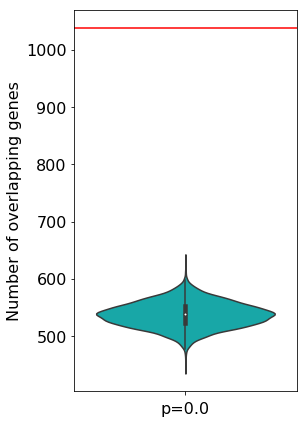

In [173]:
overlap = count_overlap_features(Pst_104E_secretome_bed,filtered_bed_fn)
random_values = Pst_secretome_value

count = 0 
for i in random_values:
    if i > overlap:
        count += 1
p = count/len(random_values)



f, ax = plt.subplots(figsize=(4, 7))
plt.style.use('fast')
sns.violinplot(y=random_values, color='c')
plt.axhline(y=overlap, color='r', linestyle='-')
#plt.title(heading, fontsize=16)
plt.ylabel('Number of overlapping genes', fontsize=16)
plt.xlabel('p=' + str(p), fontsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [222]:
count_overlap_features(Pst_104E_dict['Busco'], filtered_bed_fn)

126

In [223]:
count_overlap_features(Pst_104E_allgene_bed_fn,Pst_104E_random_fn[900])

1877

In [224]:
count_overlap_features(Pst_104E_allgene_bed_fn,filtered_bed_fn)

2394

In [207]:
fisher_exact([[810, 4637], [4454, 30249]])

(0.95412657761736053, 0.25913854377075035)

In [187]:
fisher_exact([[1039, 4637], [1000, 30249]])

(6.7778113004097476, 0.0)

In [225]:
fisher_exact([[126, 2750], [2394, 30249]])

(0.57892822966507174, 4.4873123857584314e-10)

In [179]:
!cat {Pst_104E_allgene_bed_fn} | wc

  30249  181494 1379342


In [180]:
!cat {Pst_104E_secretome_bed_fn} | wc

   4637   27822  211767


In [196]:
!cat {Pst_104E_dict['Busco']} | wc

   2740   16440  125170


In [190]:
non_covered_bases(BedTool(Pst_104E_random_fn[2]).to_dataframe())

26696752